## Problem Statement
- This project analyzes Spotify song data and builds a recommendation system to suggest songs based on user listening behavior.

## Importing necessary libraries

In [3]:
# for data manipulation and analysis
import pandas as pd
import numpy as np

# for data visualization
import matplotlib.pyplot as plt

# for warning filtering
import warnings
warnings.filterwarnings('ignore')

# for feature decomposition
from sklearn.decomposition import NMF

# for clustering
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors 

## Loading the dataframe

In [4]:
df = pd.read_csv('spotify.xls',index_col=0)
df.head()

,song_1,song_2,song_3,song_4,song_5,song_6,song_7,song_8,song_9,song_10,...,song_4991,song_4992,song_4993,song_4994,song_4995,song_4996,song_4997,song_4998,song_4999,song_5000
user_1,2,2,8,8,13,1,4,9,1,2,...,14,2,14,1,9,0,11,6,14,7
user_2,13,5,5,5,12,8,10,10,2,2,...,10,6,11,1,1,5,12,8,3,0
user_3,3,9,2,8,0,1,11,7,3,7,...,9,5,7,15,12,13,14,5,0,14
user_4,2,6,7,8,14,0,12,7,8,1,...,9,15,9,14,10,6,11,13,6,0
user_5,11,12,8,6,13,7,0,7,3,13,...,12,14,11,11,11,7,3,6,11,7


#### About the dataset
- The dataset contains the number of songs heard by each user.

In [9]:
df.isna().sum().sum()

0

- There are no missing values in the dataset,Since the dataset only contains user listening data, no further preprocessing is required.

### Non negative matrix factorization

- Apply NMF to factorize the feature matrix into two non-negative matrices.

In [10]:
nmf = NMF(n_components = 100,max_iter = 1000,random_state = 100)
x = df.values
nmf.fit(x)
user_matrix = nmf.transform(x)
song_matrix = nmf.components_.T

 By doing NMF we get two non-negative matrices.
  - user_matrix (songs × latent factors)
  - song matrix (latent factors × songs)

latent factors are the factors that capture the main components of matrix. In this dataset assume the latent factor are to be different genres.

In [14]:
user_matrix.shape

(1000, 100)

- so user matrix has 1000 users and each user interest in 100 different genres.

In [15]:
song_matrix.shape

(5000, 100)

- Likely song matrix has 5000 songs and each song represent that how much it belongs to 100 different genres.

## Building a recommendation system

We can build recommendation system in two ways
- 1. Based on user_matrix : Here we consider recommending songs based on the songs heard by users of the same interest in genres.
- 2. based on song_matrix : here we recommend songs based on genres.

## Type 1 approach : (smaller dataset)

- consider recommending song to a user in user matrix.
- calculate the euclidean distance between that user and remaining user
- find top n songs heard by nearest user
- recommend these songs to that user.

calculate the distance

In [18]:
def user_dist(U1,U2):
    return pow(sum(pow(U1[x] - U2[x],2) for x in range(len(U1))),0.5)

In [19]:
user_dist(user_matrix[0],user_matrix[1])

12.962015431901865

In [20]:
def recommend_songs(mydf,b_user,user_matrix,n_user,n_songs):
    dist = []
    for x in range(len(user_matrix)):
        if b_user != x:
            dist.append(user_dist(user_matrix[b_user],user_matrix[x]))
    nearest_user = np.argsort(dist)[:n_user]
    temp = mydf.iloc[nearest_user]
    dist = temp.max().to_dict()
    sorted_df = sorted(dist.items(),key = (lambda x:(x[1],x[0])),reverse = True)[:n_songs]
    return [x[0] for x in sorted_df]

In [21]:
recommend_songs(df,10,user_matrix,10,5)

['song_999', 'song_997', 'song_996', 'song_995', 'song_994']

## Type 2 approach
- using kmeans clustering to find the clusters of songs in same genres.
- recommend songs to all user of top heard songs in that cluster

### Finding k value for kmeans

In [22]:
wcss = []
for k in range(1,51):
    kmeans = KMeans(n_clusters = k,random_state = 5)
    kmeans.fit(song_matrix)
    wcss.append(kmeans.inertia_)

Text(0, 0.5, 'wcss')

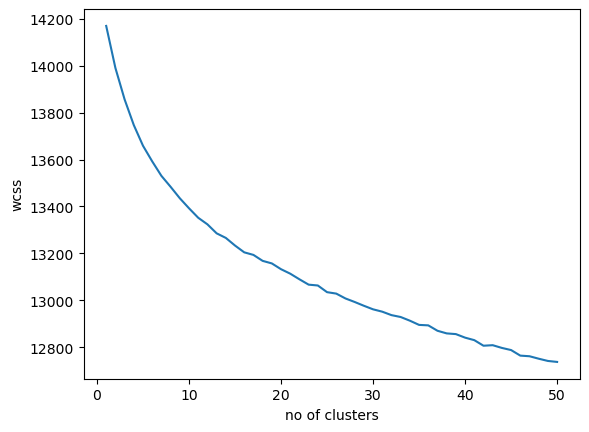

In [23]:
plt.plot(range(1,51),wcss)
plt.xlabel('no of clusters')
plt.ylabel('wcss')

In [24]:
def recommend_songs(n_cluster,df,song_matrix,song_name,n_recommendation):
    kmeans = KMeans(n_clusters = n_cluster,max_iter = 1000,random_state = 5).fit(song_matrix)
    all_songs_in_cluster = kmeans.predict(song_matrix)
    index_in_songs = df.columns.to_list().index(song_name)
    song_vector = song_matrix[index_in_songs]
    songs_in_selected_cluster = [x for x in range(len(all_songs_in_cluster))
                                if all_songs_in_cluster[x] == kmeans.predict([song_vector])]
    song_cluster = song_matrix[songs_in_selected_cluster]
    neighbors = NearestNeighbors(n_neighbors = n_recommendation)
    neighbors.fit(song_cluster)
    recommended_songs = neighbors.kneighbors([song_vector])
    songs = df.columns
    return [songs[x] for x in recommended_songs[1][0]]

In [25]:
recommend_songs(15,df,song_matrix,'song_5',5)

['song_1', 'song_241', 'song_102', 'song_158', 'song_340']

## Conclusion

- This project successfully built a recommendation system using Spotify song data. It provides song recommendations based on user listening behavior.